## Elder Problem

![Henery and Elder boundary conditions](https://www.researchgate.net/publication/362716965/figure/fig1/AS:11431281079483285@1660716381273/FIGURE-E-A-Henry-problem-boundary-conditions-B-Elder-problem-boundary-conditions_W640.jpg)

A la derecha (Figura B)  se muestran las condiciones de frontera para el problema de Elder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

plt.style.use(["seaborn-v0_8-darkgrid", "seaborn-v0_8-colorblind", "seaborn-v0_8-talk"])
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["legend.framealpha"] = 0.1

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

from scipy.integrate import solve_ivp

Could not import Matplotlib backends. Probarbly due to missing Qt.


### Geometry

Text(0.5, 1.0, 'Geometry')

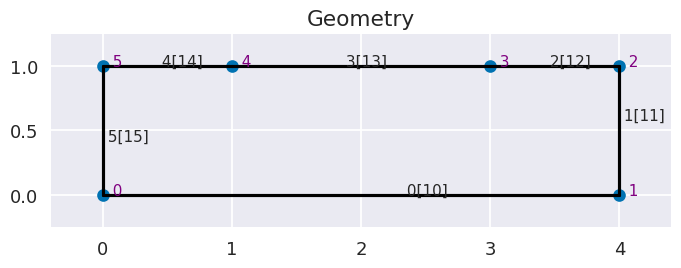

In [2]:
g = cfg.Geometry()

# points
g.point([0, 0])
g.point([4, 0])
g.point([4, 1])
g.point([3, 1], el_size=0.5)
g.point([1, 1], el_size=0.5)
g.point([0, 1])

# lines
bottom = 10
right = 11
top_right = 12
top_middle = 13
top_left = 14
left = 15
g.line([0, 1], marker=bottom)
g.line([1, 2], marker=right)
g.line([2, 3], marker=top_right)
g.line([3, 4], marker=top_middle)
g.line([4, 5], marker=top_left)
g.line([5, 0], marker=left)

# surfaces
g.surface([0, 1, 2, 3, 4, 5])

# geometry plot
plt.figure(figsize=(8,3))
cfv.draw_geometry(g,draw_axis=True)
plt.title("Geometry")

### Mesh

Text(0.5, 0.9, 'el_size_factor=0.1, N=896 nodes')

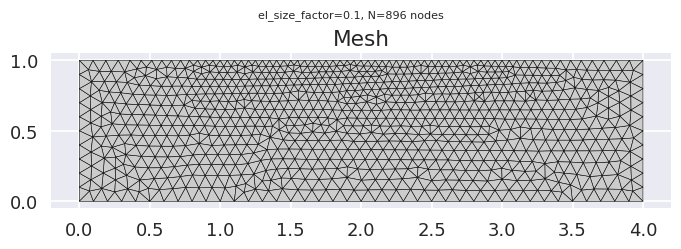

In [3]:
mesh = cfm.GmshMesh(g,el_size_factor=0.1)

coords, edof, dofs, bdofs, elementmarkers = mesh.create()
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

plt.figure(figsize=(8,3))
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True
)
plt.title(f"Mesh")
plt.suptitle(f"el_size_factor={mesh.el_size_factor}, N={coords.shape[0]} nodes", fontsize=8, y=0.90)

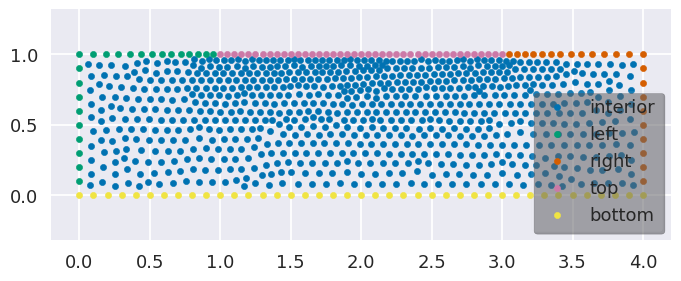

In [4]:
# nodes 
bottom_nodes = np.asarray(bdofs[bottom]) - 1
right_nodes = np.asarray(bdofs[right]) - 1
top_right_nodes = np.asarray(bdofs[top_right]) - 1
top_middle_nodes = np.asarray(bdofs[top_middle]) - 1
top_left_nodes = np.asarray(bdofs[top_left]) - 1
left_nodes = np.asarray(bdofs[left]) - 1

# elimination of intersection nodes
top_right_nodes = np.setdiff1d(top_right_nodes, top_middle_nodes)
top_left_nodes = np.setdiff1d(top_left_nodes, top_middle_nodes)
right_nodes = np.setdiff1d(right_nodes, top_right_nodes)
right_nodes = np.setdiff1d(right_nodes, bottom_nodes)
left_nodes = np.setdiff1d(left_nodes, top_left_nodes)
left_nodes = np.setdiff1d(left_nodes, bottom_nodes)

top_nodes = top_middle_nodes

# right and top_right share same condition for C
right_nodes = np.hstack((right_nodes, top_right_nodes))
# left and top_left share same condition for C
left_nodes = np.hstack((left_nodes, top_left_nodes))


boundary_nodes = np.hstack((
    bottom_nodes,
    right_nodes,
    top_nodes,
    left_nodes
))

N = coords.shape[0]
interior_nodes = np.setdiff1d(np.arange(N), boundary_nodes)


# plotting nodes
nodes_to_plot = (
    interior_nodes,
    left_nodes,
    right_nodes,
    top_nodes,
    bottom_nodes
)
labels = (
    "interior",
    "left",
    "right",
    "top",
    "bottom"
)
plt.figure(figsize=(8,3))
for nodes, label in zip(nodes_to_plot, labels):
    plt.scatter(
        coords[nodes, 0],
        coords[nodes, 1],
        label=label,
        s=20,
        alpha=1
    )
plt.axis("equal")
plt.legend()

### Discretization

In [5]:
# Psi discretization
from GFDMI import GFDMI_2D_problem as gfdm

L = np.array([0,0,0,1,0,1])
source = lambda p: 0
k = lambda p: 1

problem = gfdm(coords, faces, L, source)

problem.add_material("interior", k, interior_nodes)

problem.add_dirichlet_boundary("bottom", bottom_nodes, lambda p: 0)
problem.add_dirichlet_boundary("right", right_nodes, lambda p: 0)
problem.add_dirichlet_boundary("top", top_nodes, lambda p: 0)
problem.add_dirichlet_boundary("left", left_nodes, lambda p: 0)

# D2 discretization
D2psi, F2psi = problem.create_system_K_F()

# Dx discretization
problem.L = np.array([0,1,0,0,0,0])
Dxpsi, Fxpsi = problem.create_system_K_F()

# Dy discretization
problem.L = np.array([0,0,1,0,0,0])
Dypsi, Fypsi = problem.create_system_K_F()

# C discretization
L = np.array([0,0,0,1,0,1])
source = lambda p: 0
k = lambda p: 1

problem = gfdm(coords, faces, L, source)
problem.add_material("interior", k, interior_nodes)
problem.add_dirichlet_boundary("bottom", bottom_nodes, lambda p: 0)
problem.add_dirichlet_boundary("top", top_nodes, lambda p: 1)
problem.add_neumann_boundary("right", k, right_nodes, lambda p: 0)
problem.add_neumann_boundary("left", k, left_nodes, lambda p: 0)

# D2 discretization
D2c, F2c = problem.create_system_K_F()

# Dx discretization
problem.L = np.array([0,1,0,0,0,0])
Dxc, Fxc = problem.create_system_K_F()

# Dy discretization
problem.L = np.array([0,0,1,0,0,0])
Dyc, Fyc = problem.create_system_K_F()



###  Problem assembling

In [6]:
Ra = 400

zeros_mat = sp.csr_matrix((N, N))
zeros_vec = np.zeros(N)

Dxcpsi = Dxc.copy()
Dxcpsi = sp.lil_matrix(Dxcpsi)
Dxcpsi[boundary_nodes,:] = 0
Fxcpsi = Fxc.copy()
Fxcpsi[boundary_nodes] = 0

Dypsic = Dypsi.copy()
Dypsic = sp.lil_matrix(Dypsic)
Dypsic[boundary_nodes,:] = 0
Fypsic = Fypsi.copy()
Fypsic[boundary_nodes] = 0

Dxpsic = Dxpsi.copy()
Dxpsic = sp.lil_matrix(Dxpsic)
Dxpsic[boundary_nodes,:] = 0
Fxpsic = Fxpsi.copy()
Fxpsic[boundary_nodes] = 0

# Linear
Linear_mat = sp.vstack((
    sp.hstack((D2psi, -Ra*Dxcpsi)),
    sp.hstack((zeros_mat, D2c))
))

Linear_vec = - np.hstack((
    F2psi - Ra*Fxcpsi,
    F2c
))

# Non-Linear
def nonLinear(U):
    term1 = (Dypsic @ U[:N] + Fypsic) * (Dxc @ U[N:] + Fxc)
    term2 = (Dxpsic @ U[:N] + Fxpsic) * (Dyc @ U[N:] + Fyc)
    vec = np.hstack((
        zeros_vec,
        - term1 + term2
    ))
    return vec

def rhs(t,U):
    vec = Linear_mat @ U + Linear_vec
    vec += nonLinear(U)
    return vec

#%%
# =============================================================================
# Solving IVP with RKF45
# =============================================================================
tfinal = 0.2
tspan = [0, tfinal]

P0 = zeros_vec.copy()
C0 = zeros_vec.copy()

C0[top_nodes] = 1

U0 = np.hstack((P0,C0))

sol = solve_ivp(rhs, tspan, U0)

U = sol.y
times = sol.t

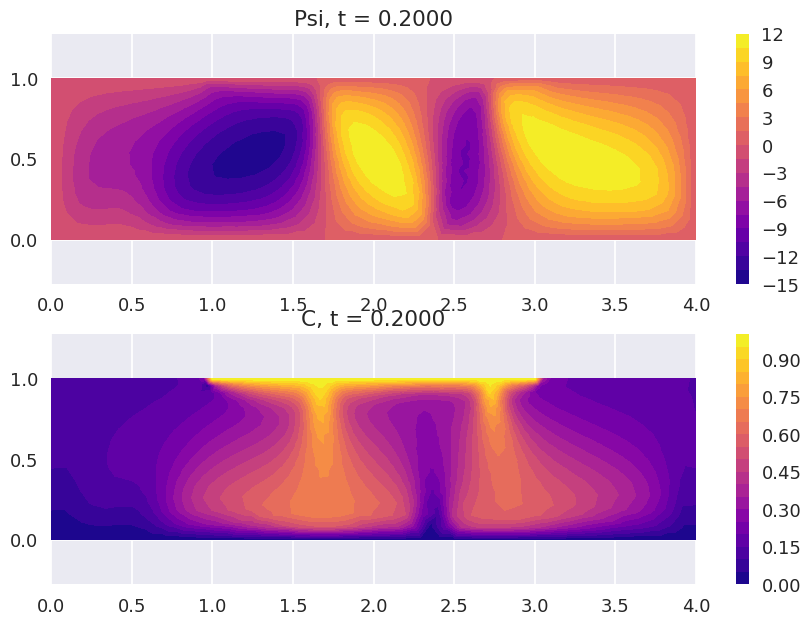

In [7]:
from matplotlib.animation import FuncAnimation 
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

index = sol.t.shape[0] - 1
cont1 = ax1.tricontourf(
    coords[:,0],
    coords[:,1],
    U[:N,index],
    cmap="plasma",
    levels=20
)
fig.colorbar(cont1)
ax1.set_title(f"Psi, t = {sol.t[index]:.4f}")
ax1.axis("equal")

cont2 = ax2.tricontourf(
    coords[:,0],
    coords[:,1],
    U[N:,index],
    cmap="plasma",
    levels=20
)
fig.colorbar(cont2)
ax2.set_title(f"C, t = {sol.t[index]:.4f}")
ax2.axis("equal")

zlims = (-10, 10)
def update(frame):
    ax1.clear()
    ax2.clear()

    cont1 = ax1.tricontourf(
        coords[:,0],
        coords[:,1],
        U[:N,frame],
        cmap="plasma",
        levels=20
    )
    ax1.set_title(f"Psi, t = {sol.t[frame]:.4f}")
    ax1.axis("equal")

    cont2 = ax2.tricontourf(
        coords[:,0],
        coords[:,1],
        U[N:,frame],
        cmap="plasma",
        levels=20
    )
    ax2.set_title(f"C, t = {sol.t[frame]:.4f}")
    ax2.axis("equal")

    return cont1, cont2

ani = FuncAnimation(fig, update, frames=U.shape[1], blit=False, interval=10)
ani.save("figures/Elder.gif", writer='imagemagick', fps=5)
plt.show()

![Elder solution](figures/Elder.gif)